# Soma Proposal Generation 

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Proposal Generation in a Single Image Patch

<div style="font-size: 17px;">
    In this section, we provide an overview of the main routines used to generate soma proposals within a single image patch. The proposal generation process follows the algorithm outlined below:
    <br><br>

<pre style="background-color: darkblue; color: white; font-family: monospace;">
    Soma Proposal Generation Algorithm
        1. Detect initial proposals - detect_blobs()
            a. Smooth image with Gaussian filter to reduce false positives.
            b. Laplacian of Gaussian to enhance regions where the intensity
               changes dramatically (i.e. higher gradient).
            c. Apply non-linear maximum filter over result from Step 1b, then
               generate initial set of proposals by detecting local maximas.
            d. Adjust each proposal by moving it to the brightest voxel in a
               small neighborhood about the initial proposal.

        2. Filter proposals - filter_proposals()
            a. Sort proposals from brightest to dimmest.
</pre>
</div>
</div>

### Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, gaussian_laplace, maximum_filter
from scipy.optimize import curve_fit
from scipy.spatial import KDTree
from time import time
from tifffile import imwrite

from aind_exaspim_soma_detection import soma_proposal_generation as spg
from aind_exaspim_soma_detection.utils import img_util, util

%matplotlib inline


### Subroutines

In [2]:
def detect_blobs(img_patch, bright_threshold, LoG_sigma):
    # Preprocess image
    smoothed = gaussian_filter(img_patch, sigma=0.5)
    LoG = gaussian_laplace(smoothed, LoG_sigma)
    max_LoG = maximum_filter(LoG, 6)

    # Detect local maximas
    peaks = list()
    for peak in peak_local_max(max_LoG, min_distance=6):
        peak = tuple([int(x) for x in peak])
        if LoG[peak] > 0:
            peaks.append(peak)
    return spg.adjust_by_brightness(img_patch, peaks, bright_threshold), LoG


def filter_centers(img_patch, centers, margin, radius=6):
    # Initializations
    if len(centers) > 0:
        kdtree = KDTree(centers)
    else:
        return list(), list()

    # Main
    filtered_centers = list()
    discared_centers = list()
    visited = set()
    for idx in np.argsort([img_patch[c] for c in centers])[::-1]:
        # Determine whether to visit center
        inbounds_bool = spg.is_inbounds(img_patch, centers[idx], d)
        not_visited_bool = centers[idx] not in visited
        if inbounds_bool and not_visited_bool:
            # Check whether to keep
            center = tuple([int(v) for v in centers[idx]])
            fit, params = spg.gaussian_fitness(img_patch, center, radius=radius)
            if fit > 0.8 and all(params[3:6] > 0.5):
                center = [int(center[i] + params[i] - radius) for i in range(3)]
                filtered_centers.append(tuple(center))
                spg.discard_nearby(kdtree, visited, center)
            else:
                discared_centers.append(center)
    return filtered_centers, discared_centers


def get_detections_img(shape, voxels):
    detections_img = np.zeros(shape)
    for voxel in voxels:
        detections_img = img_util.mark_voxel(detections_img, voxel)
    return detections_img


### Initializations

In [3]:
# Parameters
bucket = "aind-open-data"
dataset = "737563"
downsample_factor = 4

bright_threshold = 160
LoG_sigma = 4.5
d = 16  # image margin

# Open img
prefix = f"exaSPIM_737563_2024-11-13_12-16-55_flatfield-correction_2024-11-21_17-33-41_fusion_2024-11-28_00-16-41/fused.zarr/{downsample_factor}/"
img = img_util.open_img(bucket, prefix)
print("img.shape:", img.shape)


img.shape: (1, 1, 1805, 1812, 3895)


### Main

# Proposals: 2
# Rejects: 1
Runtime: 0.6397159099578857


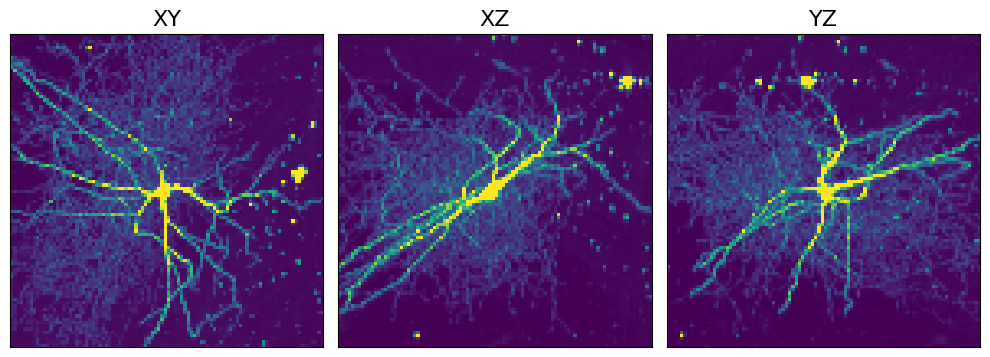

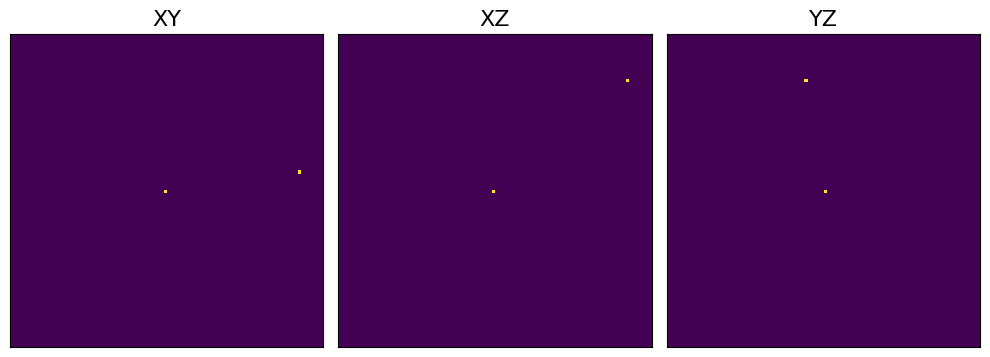

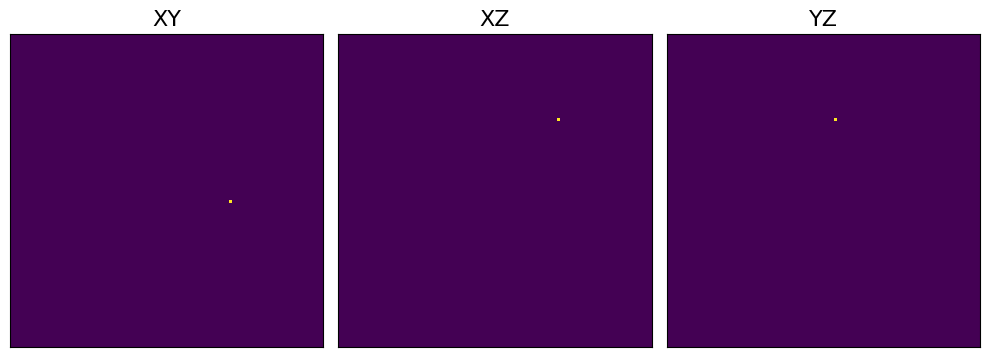

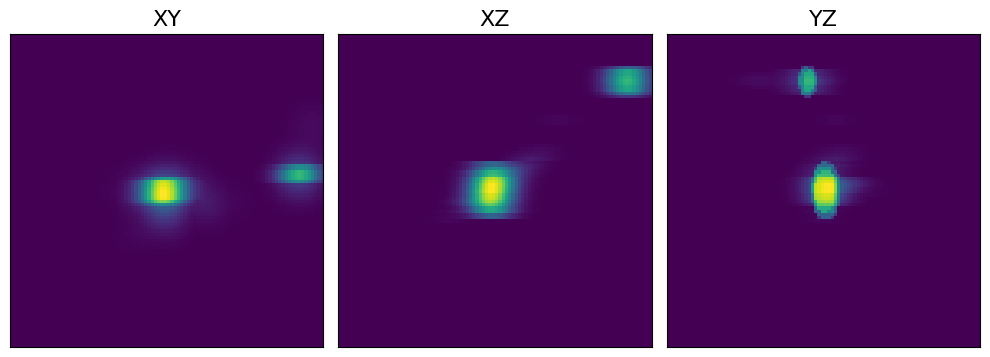

In [4]:
# Region of interest
xyz = [20731.87,11788.629,3994.1655]
shape = [128, 128, 128]

# Read image patch
voxel = img_util.to_voxels(xyz, downsample_factor=downsample_factor)
img_patch = spg.get_patch(img, voxel, shape, from_center=True)

# Proposal generation
t0 = time()
propsals, LoG_img_patch = detect_blobs(img_patch, bright_threshold, LoG_sigma)
proposals, rejects = filter_centers(img_patch, propsals, d, radius=6)

print("# Proposals:", len(proposals))
print("# Rejects:", len(rejects))
print("Runtime:", time() - t0)

# Visualize Results
proposals_img = get_detections_img(img_patch.shape, proposals)
rejects_img = get_detections_img(img_patch.shape, rejects)

img_util.plot_mips(img_patch[d:-d, d:-d, d:-d], clip_bool=True)
img_util.plot_mips(proposals_img[d:-d, d:-d, d:-d])
img_util.plot_mips(rejects_img[d:-d, d:-d, d:-d])
img_util.plot_mips(LoG_img_patch[d:-d, d:-d, d:-d])

# Save Results
imwrite("img_patch.tiff", img_patch[d:-d, d:-d, d:-d])
imwrite("proposals.tiff", proposals_img[d:-d, d:-d, d:-d])
imwrite("rejects.tiff", rejects_img[d:-d, d:-d, d:-d])

### Visualize Gaussian Fit

Fitness Score: 0.9068331566839438
Parameters: [6.11988858e+00 6.34545466e+00 5.98689086e+00 9.15216809e-01
 1.16447750e+00 1.10985902e+00 3.95900114e+03 2.03406927e+01]


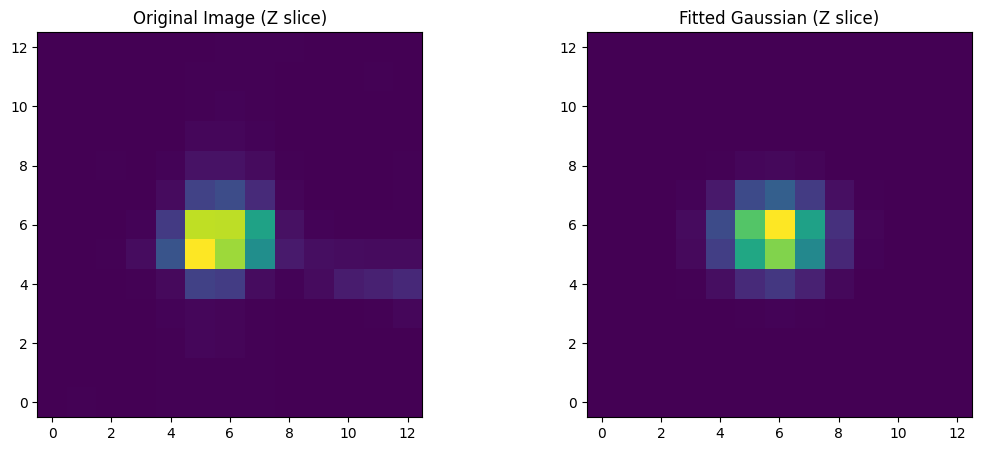

In [5]:
# Parameters
margin = 16
radius = 6

# Get valid center
while True:
    center = sample(proposals + rejects, 1)[0]
    if spg.is_inbounds(img_patch, center, margin=margin):
        break

# Get patch from img
x0, y0, z0 = center
x_min, x_max = max(0, x0 - radius), min(img_patch.shape[0], x0 + radius + 1)
y_min, y_max = max(0, y0 - radius), min(img_patch.shape[1], y0 + radius + 1)
z_min, z_max = max(0, z0 - radius), min(img_patch.shape[2], z0 + radius + 1)
subpatch = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]
img_vals = subpatch.ravel()

# Generate coordinates
xyz = [np.linspace(0, subpatch.shape[i], subpatch.shape[i]) for i in range(3)]
x, y, z = np.meshgrid(xyz[0], xyz[1], xyz[2], indexing='ij')
xyz = (x.ravel(), y.ravel(), z.ravel())

# Fit Gaussian
try:
    shape = subpatch.shape
    x0, y0, z0 = shape[0] // 2, shape[1] // 2, shape[2] // 2
    p0 = (x0, y0, z0, 2, 2, 2, np.max(subpatch), np.min(subpatch))
    params, _ = curve_fit(spg.gaussian_3d, xyz, img_vals, p0=p0)
except RuntimeError:
    pass

# Fitness quality
fitness_score = spg.fitness_quality(subpatch, xyz, params)
print("Fitness Score:", fitness_score)
print("Parameters:", params)

# Visualize image patch
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].imshow(subpatch[:, :, z0], cmap='viridis', origin='lower')
axs[0].set_title("Original Image (Z slice)")

# Visualize fitted gaussian
if params is not None:
    fitted_blob = spg.gaussian_3d((x, y, z), *params).reshape(x.shape)
    axs[1].imshow(fitted_blob[:, :, z0], cmap='viridis', origin='lower')
    axs[1].set_title("Fitted Gaussian (Z slice)")


<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Proposal Generation in Whole Brain

<div style="font-size: 17px;">
    In this section, we provide an overview of the main routines used to generate soma proposals on the scale of a whole brain.

</div>

### Imports

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

### Main

In [8]:
# Parameters
margin = 16
overlap = (36, 36, 36)
window_size = (128, 128, 128)

bright_threshold = 200
LoG_sigma = 6
save_results = False

# Initializations
output_dir = "/root/capsule/results/soma_proposals"
offsets = img_util.sliding_window_coords_3d(img, window_size, overlap)
print("# Image Patches:", len(offsets))

# Proposal generation
t0 = time()
with ThreadPoolExecutor() as executor:
    # Assign threads
    threads = list()
    for offset in offsets[0:1000]:
        threads.append(
            executor.submit(
                spg.generate_proposals,
                img,
                offset,
                margin,
                window_size,
                downsample_factor,
                bright_threshold,
                LoG_sigma,
            )
        )

    # Process results
    proposals = list()
    pbar = tqdm(total=len(threads))
    for thread in as_completed(threads):
        proposals.extend(thread.result())
        pbar.update(1)

# Global filtering
proposals = spg.global_filtering(proposals)
print("# Proposals Generated:", len(proposals))
print("Runtime:", time() - t0)

# Save results (if applicable)
if save_results:
    util.mkdir(output_dir, delete=True)
    util.write_points(output_dir, proposals, color="0.0 0.0 1.0", prefix="proposal_")

  0%|          | 0/1000 [00:00<?, ?it/s]

# Image Patches: 14801


100%|█████████▉| 999/1000 [00:38<00:00,  9.33it/s]

# Proposals Generated: 11
Runtime: 38.84072947502136
